# Latent Dirichlet Allocation on MIT projects 

## First a simple example
https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [1]:
# corpus
doc1 = "Music is good to hear because it can make you happy and you can play it too"
doc2 = "it's bad working all your life and have no time for love"
doc3 = "Enjoying music is good and relaxing. it is best to play it but you need concentration"
doc4 = "I program easy stuff. I enjoy it staying in front of the computer all the time"
doc5 = "politics is corrupt, this is a rigged system. My favorite dictator would put everything in order"
doc_complete = [doc1, doc2, doc3, doc4, doc5]

# Tokenize
from nltk.corpus import stopwords 
import string
#from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
#lemma = WordNetLemmatizer()
pstemmer = PorterStemmer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    normalized = " ".join(pstemmer.stem(word) for word in punc_free.split())
    return normalized
doc_clean = [clean(doc).split() for doc in doc_complete]

# Preparing Document-Term Matrix containing (term ID, term frequency) pairs
import gensim
from gensim import corpora
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_clean[0:]

[[u'music', u'good', u'hear', u'make', u'happi', u'play'],
 [u'it', u'bad', u'work', u'life', u'time', u'love'],
 [u'enjoy',
  u'music',
  u'good',
  u'relax',
  u'best',
  u'play',
  u'need',
  u'concentr'],
 [u'program',
  u'easi',
  u'stuff',
  u'enjoy',
  u'stay',
  u'front',
  u'comput',
  u'time'],
 [u'polit',
  u'corrupt',
  u'rig',
  u'system',
  u'favorit',
  u'dictat',
  u'would',
  u'put',
  u'everyth',
  u'order']]

#### Creating the object for LDA model using gensim library

In [4]:
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)
topics = ldamodel.print_topics(num_topics=3, num_words=3)
for t in topics: print(t)


(0, u'0.049*"order" + 0.049*"dictat" + 0.049*"everyth"')
(1, u'0.079*"good" + 0.079*"music" + 0.079*"play"')
(2, u'0.086*"enjoy" + 0.050*"time" + 0.049*"easi"')


## Now back to the MIT abstracts

In [5]:
import json
#Import dictionary with urls from file
with open('abs_dict.json', 'r') as outfile:
    abs_dict = json.load(outfile)
#If the file is not there get it from the script
if 'abs_dict' not in locals():
    import gather
    abs_dict = gather.main()
    with open('abs_dict.json', 'w') as outfile:
        json.dump(abs_dict, outfile)

#### Read the abstracts that I previously scraped and stored in the /abstract/ folder (find more details in README.md)

In [6]:
import scrape
corpus = scrape.readAbstracts()
corpus

['\nWe show how to hang a picture by wrapping rope around n nails, making a\npolynomial number of twists, such that the picture falls whenever any k out of\nthe n nails get removed, and the picture remains hanging when fewer than k\nnails get removed. This construction makes for some fun mathematical magic\nperformances. More generally, we characterize the possible Boolean functions\ncharacterizing when the picture falls in terms of which nails get removed as\nall monotone Boolean functions. This construction requires an exponential\nnumber of twists in the worst case, but exponential complexity is almost always\nnecessary for general functions.\n',
 '\nWe prove several decidability and undecidability results for the\nsatisfiability and validity problems for languages that can express solutions\nto word equations with length constraints. The atomic formulas over this\nlanguage are equality over string terms (word equations), linear inequality\nover the length function (length constrain

#### Create documents list with tokenized text

In [7]:
#Create documents list with tokenized text
# Tokenize
from nltk.corpus import stopwords 
import string
import re
stop = set(stopwords.words('english')) #NB a set is more efficient than a list
exclude = set(string.punctuation) 
#from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()
#pstemmer = PorterStemmer()
def clean_text(doc, skipWords=[]):
    for w in skipWords:
        doc = doc.replace(w,'')
    #Remove non-letters and convert to lower case
    #Remove non unicode (accents etc). Remove word that can starts with non letter and ends with non letter. 
    #"1st" "a2" "1a3" safe, "1" "123" esta' " not
    letters_only = re.sub(r'\W|\b\w*\d\b', ' ', doc.lower())
    #Split into individual words and remove stop words
    #This can be done in TfidfVectorizer/CountVectorizer but ok..
    stop_free = " ".join([i for i in letters_only.split() if i not in stop])
    #Remove punctuations should not be needed after letters_only but who knows
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #Stemming/Lemmatizing
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
documents = [clean_text(doc) for doc in corpus]

#### Turn off warnings thrown by pyLDAvis below

In [9]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Fit [LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
I am using 2-grams (i.e. features composed of two words). Five topics (N=5) can be discerned using a quite low cutoff for the words appearing in more than 95% of the documets (max_df=0.95). 

I played with the parameters and the topics seem relatively stable. Based on the pyLDAvis plot, using 1-grams leads to two partially overlapping topics with N=5. This is the reason why I chose 2-grams, although I only see 2-gram ("lower bound") within the most salient features. The fit using for 1- and 2-grams are sensitive on the maximum number of features (here max_features=1000) but seem stable when changing max_df from 50% to 95%. The fit with 1-grams on the other hand needs lower value for max_features to show a better qualitative fit (i.e. less overlap in topics).


<!--2-grams: 5 topics, max_features=1000 is well separated. a few are similar to the pdf. better than 1-gram. I see one 2-gram only ("lower bound"). max_features=1700 begins to overlap. max_df=0.95, 0.75, 0.5 have very similar fit

1-gram: 5 topics, max_features=700 is better than 1000, though overlap 2 topics with both max_df=0.95 and 0.65
-->

In [18]:
# Learn the vocabulary dictionary and return term-document matrix.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(analyzer='word', stop_words='english', #token_pattern = r'\b[a-zA-Z]{3,}\b',#strip_accents='ascii', tokenizer=lemma.lemmatize, lowercase=True, 
                        ngram_range=(1,2), max_df=0.95, min_df=5, max_features=1000)
#Fit Transform - Learn the vocabulary dictionary and return term-document matrix
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()
no_topics = 5
# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50., random_state=0, n_jobs=2)
lda.fit(tf)
# Display the terms in the topics
#tf_vectorizer.get_feature_names(): map feature indices -> feature name
#lda.components_[i,j] (topic word distribution): "weights" of terms j in topic i
def display_topics(model, feature_names, no_top_words):
    for ind, topic in enumerate(model.components_):
        print "Topic %d:" % (ind)
        print " ".join([feature_names[i]+' -'
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
print
print "LDA:"
display_topics(lda, tf_feature_names, no_top_words = 10)

/home/kinkyboy/Dropbox/MIT/Topic_modeling/MITprojects/MITprojects/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)



LDA:
Topic 0:
channel - quantum - photon - rate - source - detection - information - state - key - single -
Topic 1:
energy - current - state - galaxy - spin - weyl - result - field - device - surface -
Topic 2:
algorithm - model - problem - graph - time - method - result - function - network - data -
Topic 3:
algorithm - time - problem - bound - optimal - log - cost - lower - result - policy -
Topic 4:
model - data - network - task - method - object - learning - approach - present - information -


In [19]:
topics = ldamodel.print_topics(num_topics=5, num_words=7)
for t in topics: print t

(0, u'0.049*"order" + 0.049*"dictat" + 0.049*"everyth" + 0.049*"corrupt" + 0.049*"system" + 0.049*"favorit" + 0.049*"rig"')
(1, u'0.079*"music" + 0.079*"good" + 0.079*"play" + 0.078*"happi" + 0.078*"hear" + 0.078*"make" + 0.020*"time"')
(2, u'0.086*"enjoy" + 0.050*"time" + 0.049*"easi" + 0.049*"stay" + 0.049*"front" + 0.049*"program" + 0.049*"stuff"')


In [20]:
#Plot with pyLDAvis - see http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb
import pyLDAvis.sklearn, pyLDAvis
pyLDAvis.enable_notebook();
pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)

/home/kinkyboy/Dropbox/MIT/Topic_modeling/MITprojects/MITprojects/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      36.738004        1       1 -0.102516  0.003928
4      19.971693        1       2 -0.055526  0.147285
3      19.825693        1       3 -0.086696 -0.100207
1      14.214459        1       4  0.165135  0.046223
0       9.250151        1       5  0.079604 -0.097228, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
111   Default   295.000000        channel   295.000000  30.0000  30.0000
712   Default   240.000000        quantum   240.000000  29.0000  29.0000
389   Default   498.000000          graph   498.000000  28.0000  28.0000
25    Default  1036.000000      algorithm  1036.000000  27.0000  27.0000
90    Default   411.000000          bound   411.000000  26.0000  26.0000
644   Default   170.000000         photon   170.000000  25.0000  25.0000
503   Default   286.000000            log   286.000000  24.0000  24.0000
611   Default   290.000000        optimal   290.000000  23.0000  23.0000
723   Default   257.000000           rate   257.000000  22.0000  22.0000
560   Default   978.000000          model   978.000000  21.0000  21.0000
367   Default   115.000000         galaxy   115.000000  20.0000  20.0000
842   Default   154.000000         source   154.000000  19.0000  19.0000
857   Default   110.000000           spin   110.000000  18.0000  18.0000
229   Default   105.000000      detection   105.000000  17.0000  17.0000
988   Default   103.000000           weyl   103.000000  16.0000  16.0000
686   Default   939.000000        problem   939.000000  15.0000  15.0000
442   Default   294.000000    information   294.000000  14.0000  14.0000
906   Default   250.000000           task   250.000000  13.0000  13.0000
200   Default   511.000000           data   511.000000  12.0000  12.0000
187   Default   189.000000           cost   189.000000  11.0000  11.0000
282   Default   173.000000         energy   173.000000  10.0000  10.0000
98    Default   146.000000       capacity   146.000000   9.0000   9.0000
196   Default   156.000000        current   156.000000   8.0000   8.0000
865   Default   432.000000          state   432.000000   7.0000   7.0000
896   Default    92.000000        surface    92.000000   6.0000   6.0000
585   Default   142.000000          noise   142.000000   5.0000   5.0000
482   Default   255.000000       learning   255.000000   4.0000   4.0000
579   Default   480.000000        network   480.000000   3.0000   3.0000
656   Default   173.000000         policy   173.000000   2.0000   2.0000
610   Default   123.000000        optical   123.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
798    Topic5    38.285228   semidefinite    57.426799   1.9751  -5.1868
230    Topic5    33.142920       detector    50.244550   1.9645  -5.3311
155    Topic5    14.852316           cone    24.635247   1.8745  -6.1338
280    Topic5    15.977455       encoding    27.250537   1.8466  -6.0607
127    Topic5    39.158229         coding    66.860295   1.8455  -5.1643
284    Topic5    19.179305        entropy    32.831214   1.8430  -5.8781
842    Topic5    89.518535         source   154.836955   1.8326  -4.3375
488    Topic5    50.255502          light    87.320708   1.8281  -4.9148
120    Topic5    47.817830      classical    85.078436   1.8044  -4.9645
86     Topic5    42.151813            bit    76.203371   1.7884  -5.0906
465    Topic5    60.868644            key   117.810187   1.7202  -4.7232
905    Topic5    36.859961         target    69.482860   1.7466  -5.2248
723    Topic5   108.646188           rate   257.862999   1.5162  -4.1438
137    Topic5    54.009192  communication   121.947903   1.5661  -4.8428
126    Topic5    54.393301           code   138.258793   1.4476  -4.8357
442    Topic5    75.554094    information   294.637708   1.0196  -4.5071
91

#### Show an old-fashioned wordcloud for each topic

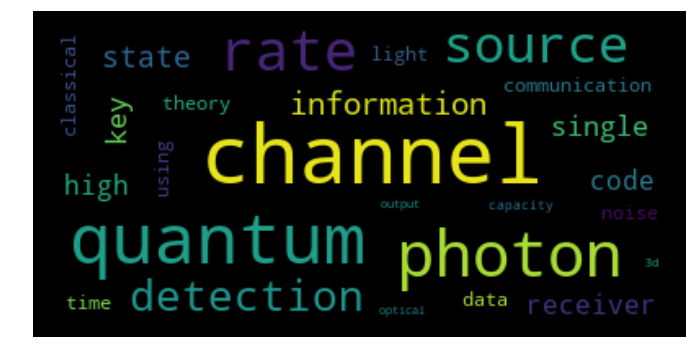

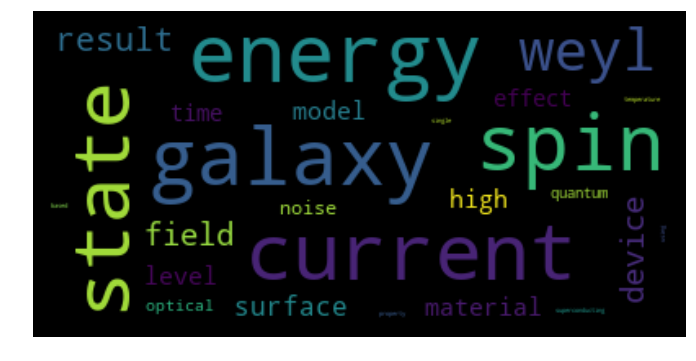

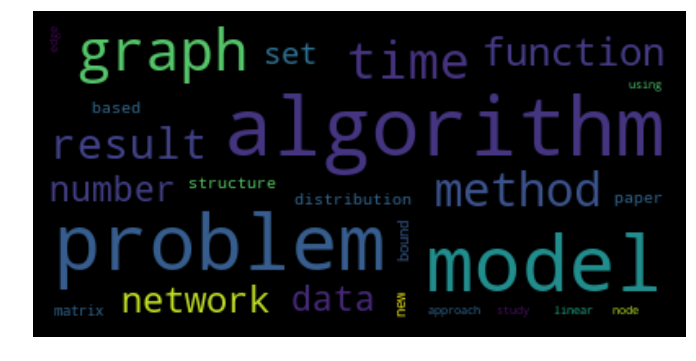

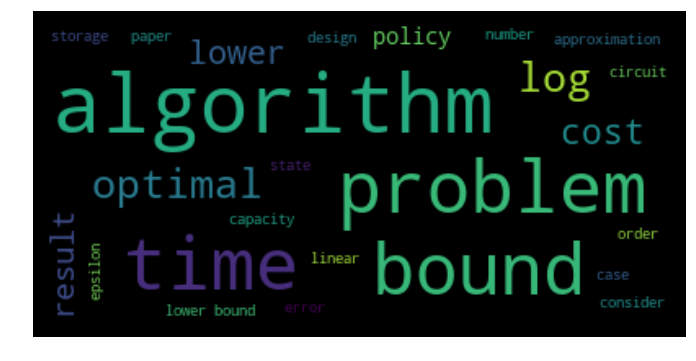

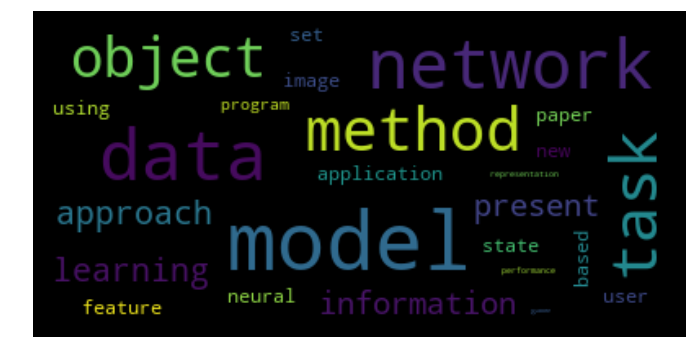

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, ImageColorGenerator

def plot_wordcloud(components,feature_names,numbest = 25):
    for t in range(len(components)):
        best_terms = dict([(feature_names[i],components[t,i]) for i in components[t].argsort()[:-numbest-1:-1].tolist()])
        # Generate a word cloud image
        wordcloud = WordCloud(width=400, height=200, margin=20, background_color='black', max_font_size=50) #random_state=i, 
        wordcloud.generate_from_frequencies(best_terms)
        # Display the generated image:
        # the matplotlib way:
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12, 6))
        plt.axis("off")
        plt.imshow(wordcloud, interpolation='bilinear')

plot_wordcloud(lda.components_,tf_feature_names,25)

In [15]:
'''# Preparing Document-Term Matrix
import gensim
from gensim import corpora
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(corpus)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)'''

'# Preparing Document-Term Matrix\nimport gensim\nfrom gensim import corpora\n# Creating the term dictionary of our courpus, where every unique term is assigned an index. \ndictionary = corpora.Dictionary(corpus)\n# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.\ndoc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]\n# Creating the object for LDA model using gensim library\nLda = gensim.models.ldamodel.LdaModel\n# Running and Trainign LDA model on the document term matrix.\nldamodel = Lda(doc_term_matrix, num_topics=5, id2word = dictionary, passes=50)'